# Create Zarr Pyramid

In this notebook, we create a Zarr pyramid store for the CMIP6 `tas` (near-surface air temperature) daily data available in NetCDF on S3. We use the [`ndpyramid`](https://github.com/carbonplan/ndpyramid) library from carbonplan. This library offers either the `pyramid_coarsen` method of aggregating data or the `pyramid_reproject` method. The `pyramid_reproject` method reprojects data to different dimensions, which usually correspond to different zoom levels when visualizing the data on a map. This is useful for making the data "square" which is how tiles are used on maps. `pyramid_coarsen` creates a multiscale pyramid via coarsening of a dataset by given factors ([ndpyramid source](https://github.com/carbonplan/ndpyramid/blob/main/ndpyramid/core.py)).

## 1.1 Install and import libraries

In [1]:
#!pip install intake h5netcdf matplotlib

In [2]:
from carbonplan_data.utils import set_zarr_encoding
from carbonplan_data.metadata import get_cf_global_attrs
import fsspec
import json
import matplotlib
from ndpyramid import pyramid_reproject, pyramid_coarsen
import numpy as np
import s3fs
import xarray as xr

import sys; sys.path.append('..')
import helpers.eodc_hub_role as eodc_hub_role

/srv/conda/envs/tile-benchmarking/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)


In [3]:
credentials = eodc_hub_role.fetch_and_set_credentials()
bucket = 'nasa-eodc-data-store'

Note: This is adapted from https://github.com/carbonplan/benchmark-maps/blob/datasets/stores/01b_cmip6_netcdf_to_zarr.ipynb.

## 1.2 Set parameters

In [4]:
#parameters
model = "GISS-E2-1-G"
variable = "tas"
anon=True

In [5]:
# Initiate fsspec filesystems for reading and writing
s3_path = f"s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/{model}/historical/r1i1p1*/{variable}/*"
fs_read = fsspec.filesystem("s3", anon=anon, skip_instance_cache=False)
fs_write = fsspec.filesystem("")

In [6]:
# Retrieve list of available months
file_paths = fs_read.glob(s3_path)
print(f"{len(file_paths)} discovered from {s3_path}")

65 discovered from s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/GISS-E2-1-G/historical/r1i1p1*/tas/*


In [7]:
file_paths[0]

'nex-gddp-cmip6/NEX-GDDP-CMIP6/GISS-E2-1-G/historical/r1i1p1f2/tas/tas_day_GISS-E2-1-G_historical_r1i1p1f2_gn_1950.nc'

## 1.3 Test we can open the files

In [8]:
fs_s3 = s3fs.S3FileSystem(anon=True)
s3_file_paths = [f's3://{file_path}' for file_path in file_paths]
fileset = [fs_s3.open(file) for file in s3_file_paths[0:2]]
ds = xr.open_mfdataset(fileset, combine='by_coords')
ds

/srv/conda/envs/tile-benchmarking/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 730, lat: 600, lon: 1440)
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 1951-12-31 12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(365, 600, 1440), meta=np.ndarray>
Attributes: (12/23)
    downscalingModel:      BCSD
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T18:41:40.796912+00:00
    frequency:             day
    ...                    ...
    history:               2021-10-04T18:41:40.796912+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       GISS-E2-1-G
    cmip6_institution_id:  NASA-GISS
    cmip6_license:         CC-BY-SA 4.0

# 2: Create Pyramid


In [9]:
VERSION = 2
PIXELS_PER_TILE = 128
longitute_length = ds[variable].lon.shape[0]
max_levels = round(np.sqrt(longitute_length/PIXELS_PER_TILE)) + 1
max_levels

4

In [10]:
# create the pyramid
LEVELS=max_levels
ds = ds.rio.write_crs('EPSG:4326')

We can use either pyramid_reproject or pyramid_coarsen. pyramid_reproject will reproject data to create square data at the dimensions required for generating traditional tiles. In this example, we assume 128 pixels per tile. `pyramid_coarsen` will maintain the aspect ratio of the underlying dimensions (lat and lon in this case) and create aggregations at each level of `factors` to create reduced resolution data.

Both produce a datatree with 4 groups at 4 levels of resolution.

`pyramid_reproject`

* Level 0: 128 x 128
* Level 1: 256 x 256
* Level 2: 512 x 512
* Level 3: 1024 x 1024

Because the dimension of our data is only 600 x 1440, it doesn't make sense to produce any additional levels beyond level 3.

When generating pyramids via `pyramid_reproject` certain pixels (i.e. data values) will be NaN to make the data square. Presumably, these NaN would be present in the image tiles produced with the coarsened dataset too since all tiles are square.

`pyramid_coarsen`

* Level 0: 360 x 150
* Level 1: 480 x 200
* Level 2: 720 x 300
* Level 3: 1440 x 600

In [29]:
%%time
pyramid_reprojected = pyramid_reproject(ds, projection='equidistant-cylindrical', other_chunks={'time': 1}, levels=LEVELS)

CPU times: user 1min 53s, sys: 29.5 s, total: 2min 22s
Wall time: 4min 47s


In [30]:
%%time
pyramid_coarsened = pyramid_coarsen(ds, factors=[4, 3, 2, 1], dims=['lat', 'lon'], boundary='trim')

CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 15.4 ms


/srv/conda/envs/tile-benchmarking/lib/python3.9/site-packages/ndpyramid/core.py:51: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  plevels[str(key)] = ds.coarsen(**kwargs).mean()
/srv/conda/envs/tile-benchmarking/lib/python3.9/site-packages/ndpyramid/core.py:51: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chu

In [31]:
#display(pyramid_reprojected), display(pyramid_coarsened)
import hvplot.xarray as hvplot
pyramid_reprojected['/0']['tas'].isel(time=0).hvplot(aspect='equal')

:Image   [x,y]   (tas)

Note this is slow because the coarsened pyramid has not been rechunked to 1 time step per chunk.

In [32]:
%%time
pyramid_coarsened['/0']['tas'].isel(time=0).hvplot(aspect='equal')

CPU times: user 9.11 ms, sys: 4.05 ms, total: 13.2 ms
Wall time: 12.8 ms


:Image   [lon,lat]   (tas)

We can use either dataset, but will use the reprojected dataset for now since that is the method benchmark-maps uses (see https://github.com/carbonplan/benchmark-maps/blob/main/notebooks/utils.py#L149-L155).

In [39]:
datasets = {'reprojected': pyramid_reprojected, 'coarsened': pyramid_coarsened }

for dt in datasets.values():
    # modify the data in the pyramid
    for child in dt.children.values():
        child.ds = set_zarr_encoding(
            child.ds, codec_config={"id": "zlib", "level": 1}, float_dtype="float32"
        )
        if 'x' in child.ds and 'y' in child.ds:
            child.ds = child.ds.rename({'x': 'lon', 'y': 'lat'})
            # Don't store multiple chunks per spatial region, they're small enough!
        child.ds = child.ds.chunk({"lat": -1, "lon": -1, "time": 1})
        child.ds[variable].attrs.clear()
    dt.attrs = get_cf_global_attrs(version=VERSION)
    dt.ds.attrs['multiscales'] = [{'datasets': {}, 'metadata': {'version': VERSION }}]
    for level in range(LEVELS):
        slevel = str(level)
        dt.ds.attrs['multiscales'][0]['datasets'][level] = {}
        dt.ds.attrs['multiscales'][0]['datasets'][level]['pixels_per_tile'] = PIXELS_PER_TILE    

In [40]:
%%time

for k, dt in datasets.items():
    # write the pyramid to zarr
    fs = s3fs.S3FileSystem(anon=False)
    store_name = f"test-data/pyramid-{k}/CMIP6_daily_{model}_{variable}.zarr"
    save_path = s3fs.S3Map(root=f"{bucket}/{store_name}", s3=fs, create=True)
    dt.to_zarr(save_path)    

CPU times: user 4min 8s, sys: 23.3 s, total: 4min 32s
Wall time: 5min 19s


In [41]:
shared_vars = {
    'variable': variable,
    'extra_args': { 'multiscale': True }    
}
cmip6_datasets = {
    'cmip6-pyramid-reprojected': {
        'dataset_url': f"s3://{bucket}/test-data/pyramid-reprojected/CMIP6_daily_{model}_{variable}.zarr",
        'lat_extent': [-89, 89],
        'lon_extent': [-179, 179],         
        **shared_vars
    },
    'cmip6-pyramid-coarsened': {
        'dataset_url': f"s3://{bucket}/test-data/pyramid-coarsened/CMIP6_daily_{model}_{variable}.zarr",
        'lat_extent': [-59, 89],
        'lon_extent': [-179, 179],      
        **shared_vars
    }    
}
with open('cmip6-pyramid-datasets.json', 'w') as f:
    f.write(json.dumps(cmip6_datasets))
    f.close()

## Checking our work

Below is some code to open and plot the pyramids to make sure everything worked as expected.

In [42]:
pyramid_ds = xr.open_zarr(save_path, consolidated=True, group=2)

In [43]:
pyramid_ds['tas']

<xarray.DataArray 'tas' (time: 730, lat: 300, lon: 720)>
dask.array<open_dataset-tas, shape=(730, 300, 720), dtype=float32, chunksize=(1, 300, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 -59.75 -59.25 -58.75 -58.25 ... 88.75 89.25 89.75
  * lon          (lon) float32 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
    spatial_ref  float64 ...
  * time         (time) object 1950-01-01 12:00:00 ... 1951-12-31 12:00:00

In [44]:
print(save_path)
pyramid_ds = xr.open_zarr(save_path, consolidated=True)
pyramid_ds.multiscales[0]['datasets']

{'0': {'pixels_per_tile': 128},
 '1': {'pixels_per_tile': 128},
 '2': {'pixels_per_tile': 128},
 '3': {'pixels_per_tile': 128}}

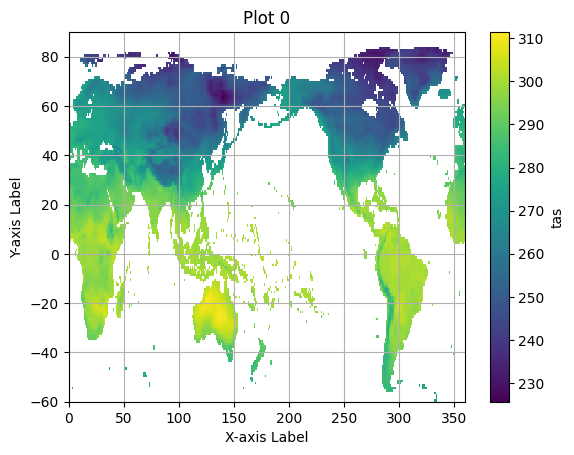

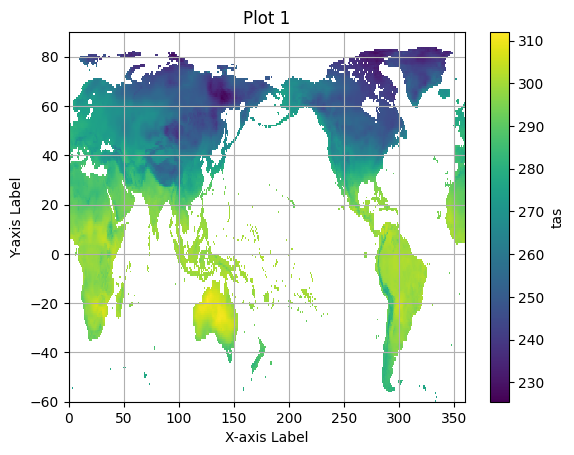

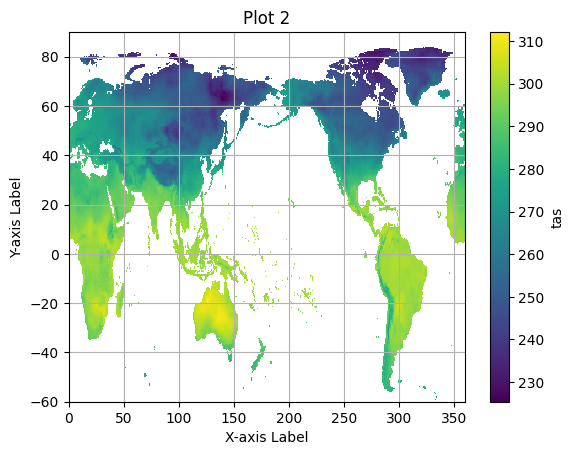

In [ ]:
import matplotlib.pyplot as plt

for group in pyramid_ds.multiscales[0]['datasets'].keys():
    
    pyramid_group = xr.open_zarr(save_path, consolidated=True, group=group)
    zoom_zero = pyramid_group.isel(time=0)
    
    plt.figure()  # Create a new figure for each plot.
    zoom_zero.tas.plot()
    plt.title(f"Plot {group}")  # Set a title for each plot.
    plt.xlabel("X-axis Label")
    plt.ylabel("Y-axis Label")
    plt.grid(True)
    plt.show()